In [15]:
import os
import librosa
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Laad fragmenten en labels uit CSV
df = pd.read_csv('Data/fragments_data.csv')
audio_files = df['fragment'].tolist()
labels = df['labels'].tolist()


X = []
y = []

for file, label in zip(audio_files, labels):
    y_val, sr = librosa.load("audio_fragments/" + file, sr=None)  # laad audio
    mfcc = librosa.feature.mfcc(y=y_val, sr=sr, n_mfcc=13)  # extract MFCCs
    mfcc_mean = np.mean(mfcc.T, axis=0)
    chroma = librosa.feature.chroma_stft(y=y_val, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)  # gemiddelde over tijd
    features = np.concatenate([mfcc_mean, chroma_mean])
    X.append(features)  # combineer MFCCs en chroma
    y.append(label)

# Convert naar numpy arrays
X = np.array(X)
y = np.array(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression model
model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

# Voorspelling
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1872
  warnings.warn(
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=957
  warnings.warn(
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=894
  warnings.warn(
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1319
  warnings.warn(
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\librosa\core\spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=360
  warnings.warn(
c:\Users\Gijs 

Accuracy: 0.5800256081946222


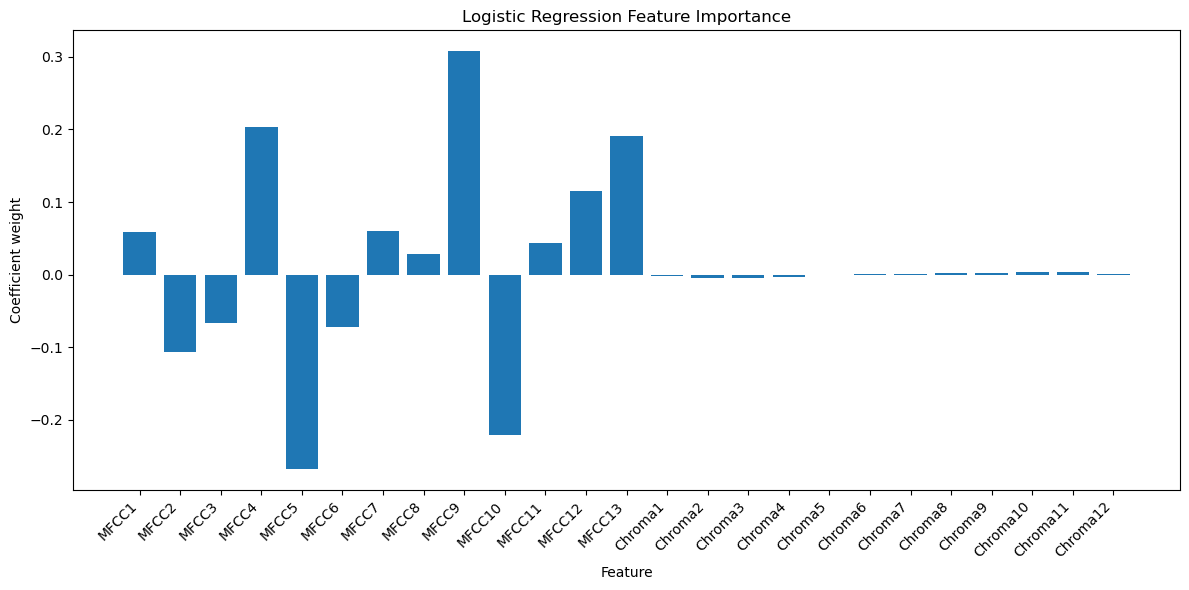

In [16]:
import matplotlib.pyplot as plt

# Haal de coëfficiënten op (een array van lengte n_features)
coeffs = model.coef_[0]

# Bouw labels: MFCC1…MFCC13 + Chroma1…Chroma12 (of langer, afhankelijk van jouw chroma-dimensie)
n_mfcc = 13
n_chroma = coeffs.shape[0] - n_mfcc
feature_labels = [f"MFCC{i+1}" for i in range(n_mfcc)] + [f"Chroma{i+1}" for i in range(n_chroma)]

# Plot de balkjes
plt.figure(figsize=(12, 6))
plt.bar(range(len(coeffs)), coeffs)
plt.xticks(range(len(coeffs)), feature_labels, rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Coefficient weight")
plt.title("Logistic Regression Feature Importance")
plt.tight_layout()
plt.show()


<Figure size 1500x1500 with 0 Axes>

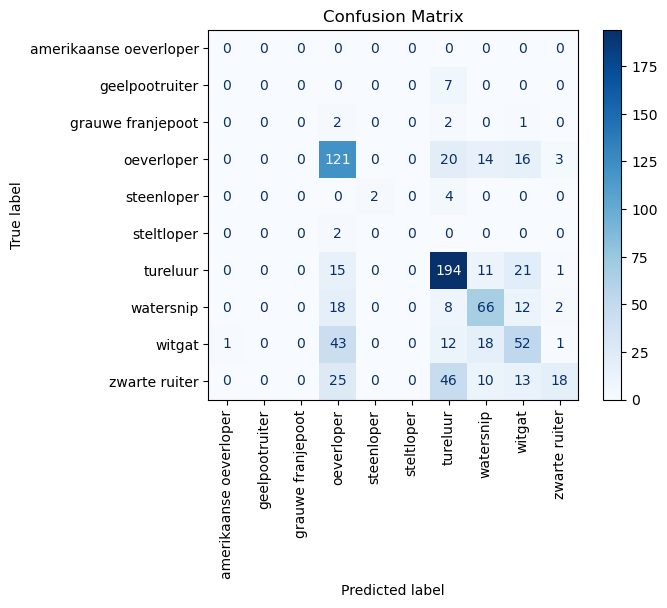

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))

# Plot
plt.figure(figsize=(15, 15))
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.show()

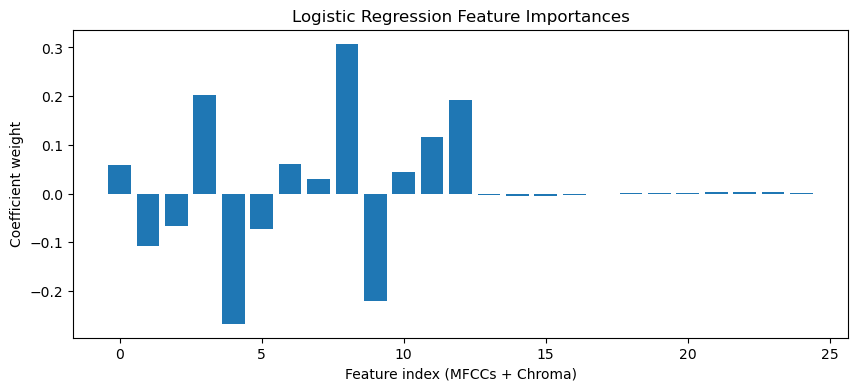

In [20]:
import matplotlib.pyplot as plt

# Coëfficiënten van het model
coef = model.coef_[0]

plt.figure(figsize=(10, 4))
plt.bar(range(len(coef)), coef)
plt.xlabel('Feature index (MFCCs + Chroma)')
plt.ylabel('Coefficient weight')
plt.title('Logistic Regression Feature Importances')
plt.show()

c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
c:\Users\Gijs Minnen\anaconda3\Lib\site-packages\sklearn\metrics\_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


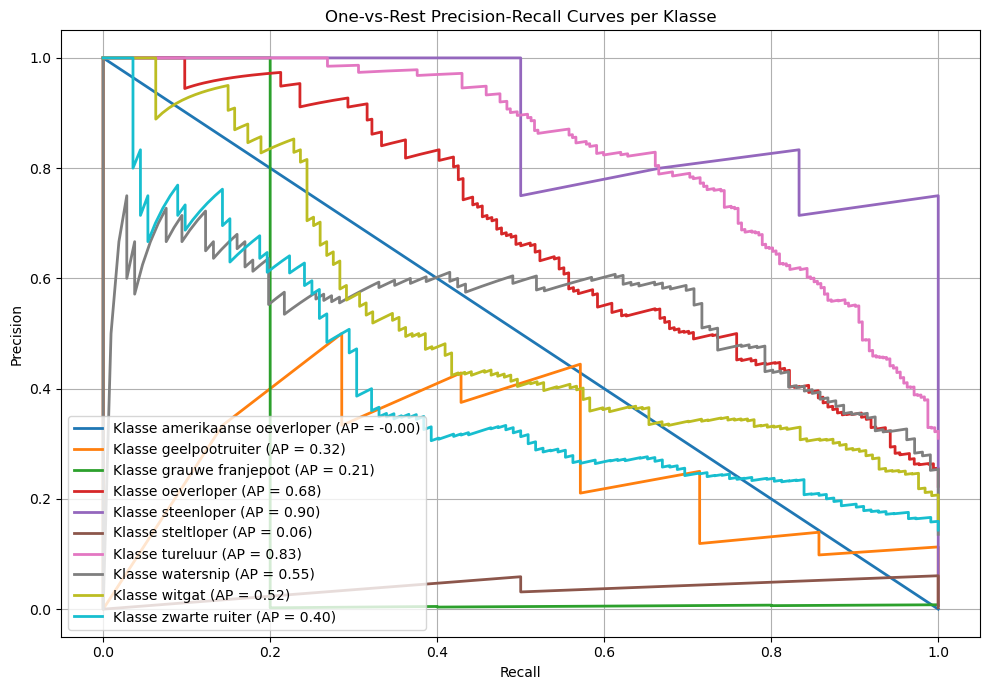

In [25]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import numpy as np

# Zet labels om naar binair formaat (One-vs-Rest)
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
y_score = model.predict_proba(X_test)

# Gemiddelde precision per klasse
plt.figure(figsize=(10, 7))

for i in range(len(classes)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    avg_precision = average_precision_score(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, lw=2, label=f'Klasse {classes[i]} (AP = {avg_precision:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('One-vs-Rest Precision-Recall Curves per Klasse')
plt.legend(loc='lower left')
plt.grid()
plt.tight_layout()
plt.show()
